# 9. NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences, text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

%matplotlib inline

## Example NLP problems

1. Classification
2. Text Generation
3. Machine Translation
4. Voice Assistants

## Other Sequence Problems

1. one-to-one
2. one-to-many
3. many-to-one
4. many-to-many
5. many-to-many (synchronised)

## What we're going to cover

* Dowloading and preparing a text dataset
* How to prepare text data for modelling (tokenization and embedding)
* Setting up multiple modelling experiments with recurrent neural networks (RNNs)
* Building a text feature extraction model using TensorFlow Hub
* Finding the most wrong prediction examples
* Using a model we've built to make predictions on text from the wild

## NLP inputs and outputs

Is this tweet a disaster or not?

Input                        -> Model -> Disaster/Not Disaster <br>
[batch_size, embedding_size]

Shape = [None, 512]<br>
      Or <br>
Shape = [32, 512]

1. Turn all data into numbers (neural networks can't handle text/natural language)
2. Make sure all of your sequences are the right shape (pad sequences which don't fit)

## Recurrent Neural Network

|Hyperparameter/Layer type|What does it do?|Typical values|
|-------------------------|----------------|--------------|
|Input text(s)|Target texts/sequences you'd like to discover patterns in|Whatever you can represent as text or a sequence|
|Input layer|Takes in target sequence|input_shape = [batch_size, embedding_size] or [batch_size, sequence_shape]|
|Text Vectorization layer|Maps input sequences to numbers|Multiple, can create with `tf.keras.layers.experimental.preprocessing.TextVectorization`|
|Embedding|Turns mapping of text vectors to embedding matrix (representation of how words relate)|Multiple, can create with `tf.keras.layers.Embedding`|
|RNN cell(s)|Finds pattern in sequences|SimpleRNN, LSTM, GRU|
|Hidden activation|Adds non-linearity to learned features (non-straight lines)|Usually Tanh (hyperbolic tangent) (`tf.keras.activations.tanh`)|
|Pooling layer|Reduces the dimensionality of learned sequence features (usually for Conv1D models)|Average(`tf.keras.layers.GlobalAveragePooling1D`) or Max (`tf.keras.layers.GlobalMaxPool1D`)|
|Fully connected layer|Further refines learned features from recurrent layers|`tf.keras.layers.Dense`|
|Output layer|Takes learned features and outputs them in shape of target labels|output_shape = [number_of_classes](eg 2 for disaster,Not Disaster)|
|Output activation|Adds non-linearities to output layer|`tf.keras.activations.sigmoid` (binary classification) or `tf.keras.activations.softmax`|



Code specimen
```
# Create LSTM Model
from tensorflow.keras import layers
inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs) # turn the input sequence into numbers
x = embedding(x) # create embedding matrix
x = layers.LSTM(64, activation = "tanh")(x) # return vector for whole sequence
outputs = layers.Dense(1, activation = "sigmoid")(x) # create output layer
model = tf.keras.Model(inputs, outputs, name = "LSTM_model")

# Compile the model
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history = model.fit(train_sentences, train_labels, epochs = 5)
```

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1660 Ti with Max-Q Design (UUID: GPU-98341486-1e20-1f70-bede-e43364f0f019)


## Get Helper Functions

In [3]:
from extras.helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's Introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

In [6]:
!curl "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip" --output "Data/NLP/nlp_getting_started.zip"
from zipfile import ZipFile
if os.path.exists("Data/NLP/nlp_getting_started") == False:
    zip_file = ZipFile("Data/NLP/nlp_getting_started.zip")
    zip_file.extractall("Data/NLP")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  593k  100  593k    0     0  2993k      0 --:--:-- --:--:-- --:--:-- 3010k


## Visualizing a text dataset

In [9]:
train_df = pd.read_csv('Data/NLP/train.csv')
test_df = pd.read_csv('Data/NLP/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
len(train_df), len(test_df)

(7613, 3263)

In [18]:
# Let's visualize some random training examples
random_index = np.random.choice(len(train_df), size = 5)
random_training_data = train_df_shuffled.iloc[random_index, :]
for row in random_training_data[['text','target']].itertuples():
    _, text, target = row
    print(f'Target: {target}', "(real disaster)" if target > 0 else "(not real disaster)")
    print(f'Text:\n{text}\n')
    print('---\n')

Target: 0 (not real disaster)
Text:
Imagini noi si 2 clipuri The Hobbit: The Desolation of Smaug -... http://t.co/j6CfwUKofE #cliptv #desolationofsmaug #poze #thehobbit

---

Target: 1 (real disaster)
Text:
We are getting some reports of flooding near Jonesboro High School. Please use caution when driving in the area. Turn around don't drown!

---

Target: 0 (not real disaster)
Text:
#NowPlaying Fitz And The Tantrums - Out Of My League on #Crush #Listen http://t.co/Pwd5L0GLkV #NowPlaying

---

Target: 0 (not real disaster)
Text:
We know this is bad for the bees - don't give in to pressure from short term profit obsessed chemical companies... http://t.co/aNuTOopKF4

---

Target: 0 (not real disaster)
Text:
@DavidCovucci We can't because a sinkhole swallowed every taco place in the neighborhood

---



### Split data into training and validation sets

In [20]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['target'].to_numpy(), test_size = 0.1, random_state = 42)

In [21]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [22]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting Text to Numbers

### Tokenization vs Embedding

Tokenization - straight mapping from token to number (can be modelled but quickly gets too big) <br>
Embedding - richer representation of relationships between token (can limit size + can be learned)

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word/character/phoneme) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(
    max_tokens = None, # how many words in the vocabulary (automatically add <OOV>)
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    ngrams = None, # create groups of n-words?
    output_mode = 'int', # how to map tokens to numbers
    output_sequence_length = None, # pad each sequence to the max length
    # pad_to_max_tokens = True
)

In [26]:
# Find the average number of tokens (words) in the training tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [28]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (eg how many words from a Tweet does a model see?)

In [30]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

In [31]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [32]:
# Create a sample sentence and tokenizer it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [33]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f'Original Sentence:\n{random_sentence}\n\nVectorized version:\n{text_vectorizer([random_sentence])}')

Original Sentence:
FedEx no longer will ship potential bioterror pathogens - FedEx Corp. (NYSE: FDX) will no longer deliver packages ... http://t.co/2kdq56xTWs

Vectorized version:
[[ 577   40  600   38  810 1615  609 1801  577 5912    1    1   38   40
   600]]


In [34]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'Most common words: {top_5_words}')
print(f'Least common words: {bottom_5_words}')

Number of words in vocab: 10000
Most common words: ['', '[UNK]', 'the', 'a', 'in']
Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

Word embedding is a rich numerical form of representing data

The parameters we care most about for our embedding layer:
1. `input_dim` - the size of our vocabulary
2. `output_dim` - the size of the output embedding vector, for example a value of 100 would mean each token gets represented by a vector 100 long
3. `input_length` - length of the sequences being passed to the embedding layer

In [40]:
embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      embeddings_initializer = "uniform",
                                      input_length = max_length)

embedding

In [41]:
random_sentence  = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\nEmbedded version:\n{embedding(text_vectorizer([random_sentence]))}')
sample_embed = embedding(text_vectorizer([random_sentence]))

Original text:
@Jones94Kyle oh fuck sake he is dead ????
Embedded version:
[[[-0.01596582 -0.02725614  0.02970581 ... -0.03400115 -0.02339556
   -0.0385849 ]
  [ 0.02843285  0.01470726  0.02932814 ...  0.04255323 -0.0033365
    0.00822699]
  [ 0.0335401  -0.03826281  0.03658959 ... -0.02730137 -0.0040067
   -0.00331769]
  ...
  [ 0.02266992  0.04203521 -0.02998855 ... -0.04615408  0.02614564
    0.00210898]
  [ 0.02266992  0.04203521 -0.02998855 ... -0.04615408  0.02614564
    0.00210898]
  [ 0.02266992  0.04203521 -0.02998855 ... -0.04615408  0.02614564
    0.00210898]]]


In [43]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01596582, -0.02725614,  0.02970581, -0.0251513 ,  0.01522633,
        -0.04726894,  0.0362272 ,  0.01818464, -0.04097315, -0.02615193,
        -0.03287659,  0.01290735,  0.01942286,  0.01032597,  0.02723004,
         0.01314802,  0.04604669, -0.02436283,  0.03023603, -0.04968384,
        -0.02053014, -0.01739766,  0.01723601,  0.01297421,  0.04373344,
        -0.00753868, -0.01254959, -0.04324947, -0.01004431, -0.0066695 ,
        -0.03640427,  0.01424516,  0.04301449, -0.03569065,  0.02308332,
        -0.00159805,  0.04405992, -0.02610273,  0.00960187,  0.02265448,
        -0.04227202,  0.04474261, -0.02060677,  0.03840687,  0.04872339,
        -0.02099302, -0.03198811,  0.01822981, -0.0085814 ,  0.00981631,
        -0.04951754, -0.0208105 , -0.03188933, -0.04300619,  0.00244892,
         0.01942668, -0.04536454,  0.02942969, -0.03894325,  0.03694764,
         0.00771285, -0.01682173, -0.03195217,  0.04885786, -0.04024651,
  

## Modelling a text dataset (and running a series of experiments)

|Experiment Number|Model|
|-----------------|-----|
|0|Naive Bayes with TF-IDF encoder (baseline) [Sklearn ML Map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)|
|1|Feed-forward neural network (dense model)|
|2|LSTM (RNN)|
|3|GRU (RNN)|
|4|Bidirectional-LSTM (RNN)|
|5|1D Convolutional Neural Network|
|6|TensorFlow Hub Pretrained Feature Extractor|
|7|TensorFlow Hub Pretrained Feature Extractor (10% of data)|

### Model 0: Getting a baseline

As with all machine learning modelling experiments, its important to create a baseline so we've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> Its common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

model_0 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
        ('clf', MultinomialNB()) # model the text
    ]
)

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [45]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [46]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time. However, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

> For a deep overview of many different evaluation methods, see the sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

Use the `precision_recall_fscore_support` for getting all the metrics via one function call

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from extras.helper_functions import make_confusion_matrix

def evaluate_predictions(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
    make_confusion_matrix(y_true, y_pred, classes = ["Not Disaster", "Disaster"])
    return {"Accuracy":accuracy,"Precision": precision, "Recall": recall, "F1_Score":f1}

Accuracy: 0.7926509186351706
Precision: 0.8861788617886179
Recall: 0.6264367816091954
F1-Score: 0.734006734006734


{'Accuracy': 0.7926509186351706,
 'Precision': 0.8861788617886179,
 'Recall': 0.6264367816091954,
 'F1_Score': 0.734006734006734}

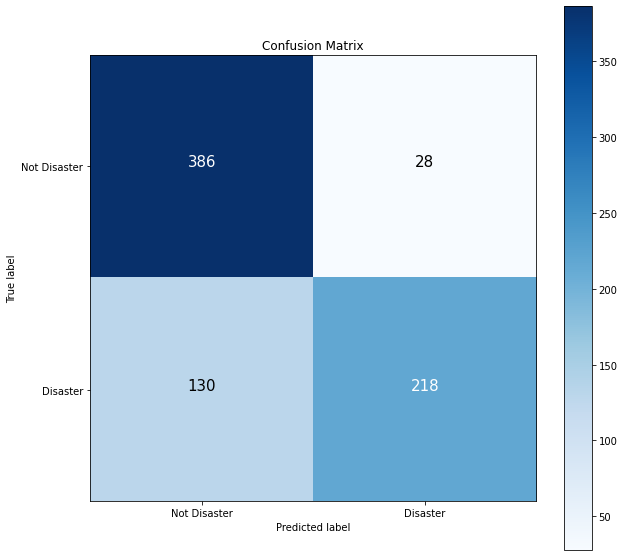

In [55]:
evaluate_predictions(val_labels, baseline_preds)

### Model 1: Feed-forward neural network (dense model)


In [56]:
# Create a tensorboard callback (need to create a new one for each model)

from extras.helper_functions import create_tensorboard_callback

# Create a directory to save Tensorboard logs
SAVE_DIR = "TensorBoard/NLP"

In [68]:
# Build model with the Functional API

inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # turn numbers into word embeddings
# x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
# x = tf.keras.layers.GlobalMaxPool1D(name = "max_pooling_1d")(x)
x = tf.keras.layers.GlobalAveragePooling1D(name = "global_average_pooling")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1')

In [69]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling (Glo  (None, 128)              0         
 balAveragePooling1D)                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [70]:
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [71]:
history_model_1 = model_1.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_1_dense')]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_1_dense/20220713-231825
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.5753 - accuracy: 0.7717 - val_loss: 0.5289 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4108 - accuracy: 0.8443 - val_loss: 0.4661 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3254 - accuracy: 0.8739 - val_loss: 0.4552 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2696 - accuracy: 0.9012 - val_loss: 0.4654 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2280 - accuracy: 0.9183 - val_loss: 0.4829 - val_accuracy: 0.7835


In [74]:
results_model_1 = model_1.evaluate(val_sentences, val_labels)
results_model_1

24/24 [==============================] - 0s 13ms/step - loss: 0.4829 - accuracy: 0.7835


[0.48294728994369507, 0.7834645509719849]

In [75]:
model_preds = model_1.predict(val_sentences)
model_preds.shape

24/24 [==============================] - 0s 9ms/step


(762, 1)

In [78]:
pred_logits = tf.squeeze(tf.round(model_preds))
pred_logits[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Accuracy: 0.7834645669291339
Precision: 0.8144329896907216
Recall: 0.6810344827586207
F1-Score: 0.7417840375586854


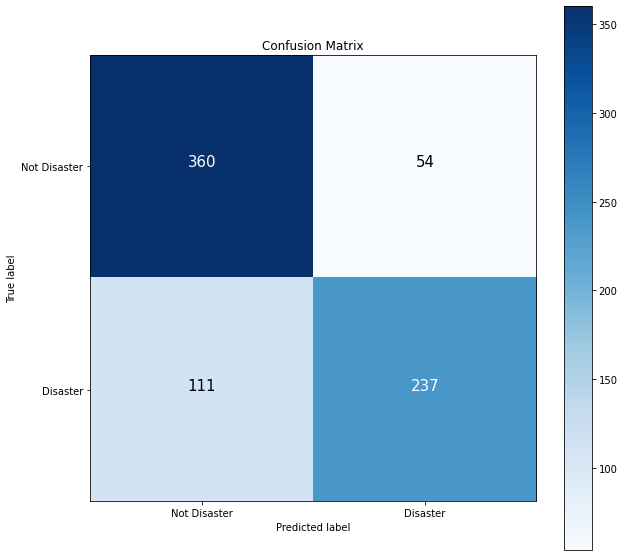

In [80]:
model_1_results = evaluate_predictions(val_labels, pred_logits)

## Visualising model's learned embeddings

In [81]:
# Get the vocabulary from the text vectorization layer
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [88]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data, which have been learned for ~5 epochs)

embed_weights = model_1.get_layer('embedding_1').get_weights()[0]
embed_weights.shape

(10000, 128)

Now we've got the embedding matirx our model has learned to represent our tokens. Lets see how we can visualise it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [90]:
import io

out_v = io.open('Embeddings/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('Embeddings/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

<img src="extras/Artifacts/word_embedding_clusters.png"></img>

We can visualise the above embeddings using [TensorFlow Projector](http://projector.tensorflow.org/) and clicking on the "load" button on the left hand side

📖Resources: For more on word embeddings, refer to:
* Jay Alammar's visualised word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNNs)

RNNs are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input

If you want an overview of the internals of a recurrent neural network, see the following:

- MIT's [sequence modelling lecture](https://youtu.be/qjrad0v0uJE)
- Chris Olah's [intro to LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- Andrej Karpathy's [the unreasonable effectiveness of recurrent neural networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

<img src="extras/Artifacts/RNN.png"></img>